## START

In [1]:
import pandas as pd
import pyreadr
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
#STARTING POINT DATA
#extract patients from England, Wales, Scotland
# Training data -> England
# External evaluation -> Wales and Scotland
features = pd.read_csv('../../Clean_data/data_features_2vs1_2016-2018_21102024.csv', low_memory=False)
# features = features.drop(columns=['Unnamed: 0']) #drop the first column - index
features = features.drop(columns=['id',
       'practice_id.y', 'event_date.x', 'recorded_date', 'visit_id', 'code_id',
       'snomed_id', 'numeric_1', 'numeric_2', 'created_datetime',
       'updated_datetime', 'event_date.y',]) #drop unnecessary columns
features.rename(columns={'practice_id.x': "practice_id"}, inplace=True) #fix practice_id column name
features.drop_duplicates('patid', inplace=True)
features.reset_index(drop=True, inplace=True)
#add paractice information

def fix_system(x): #clean system variable
    if ('SystmOne' in x):
        return 'SystemOne'
    elif ('emis' in x) | ('Emis' in x) | ('EMIS' in x):
        return 'EMIS'
    elif ('Vision' in x):
        return 'Vision'
    elif ('iSoft' in x):
        return 'iSoft'
    elif ('Microtest' in x):
        return 'Microtest'
    else:
        return 'unknown'
    

    
# practice = pyreadr.read_r('../ServerData_13Oct2020/d_practice.Rdata')
# practice = practice['d_practice']
practice = pd.read_csv('../../Clean_data/practice_information.csv')
practice['system'] = practice.apply(lambda x: fix_system(x.system), axis=1)

features = features.merge(practice[['practice_id','postcode_district','imd_decile','Country','County','LocalAuthority','OutputAreaClassification', 'system']], on='practice_id',how='inner')
features.reset_index(drop=True, inplace=True)
features.shape

print('This is the starting point for SAMPLE SELECTION -> all asthma patients from England, Wales, Scotland who were active between 2016-1-1 to 2018-12-31. It is separated into: ')

def add_set(x):
    if x == 'England':
        return 'training'
    elif (x=='Wales')|(x=='Scotland'):
        return 'evaluation'

features = features[features.Country!=''] #remove data without Country information
features['set'] = features.Country.apply(lambda x: add_set(x))


#print data size
print(f'data size: {features.shape}')
print('Training dataset: ', features[features.set == 'training'].shape)
print('External evaluation dataset : ', features[features.set == 'evaluation'].shape)
features.reset_index(inplace=True, drop=True)

master_features = features #keep the original data

This is the starting point for SAMPLE SELECTION -> all asthma patients from England, Wales, Scotland who were active between 2016-1-1 to 2018-12-31. It is separated into: 
data size: (716487, 56)
Training dataset:  (682516, 56)
External evaluation dataset :  (25937, 56)


In [4]:
var_names_fix = {
    'patid': 'patid', #identifier
    'set': 'set', #data split information
    'sex': 'Sex', #1
    'age': 'Age', #2
    'BMI': 'BMI', #3
    'ethnic_group': 'Ethnicity', #4
    'smokingStatus': 'Smoking status', #5
    'imd_decile': 'Index of multiple deprivation', #6
    'CharlsonScore': 'Charlson comorbidity index', #7
    'count_rhinitis': 'Comorbidities - rhinitis', #8
    'count_cardiovascular': 'Comorbidities - cardiovascular', #8
    'count_heartfailure': 'Comorbidities - heart failure', #8
    'count_psoriasis': 'Comorbidities - psoriasis', #8
    'count_anaphylaxis': 'Comorbidities - anaphilaxis', #8
    'count_diabetes': 'Comorbidities - diabetes', #8
    'count_ihd': 'Comorbidities - ischaemic heart disease', #8
    'count_anxiety': 'Comorbidities - anxiety', #8
    'count_eczema': 'Comorbidities - eczema', #8
    'count_nasalpolyps': 'Comorbidities - nasalpolyps', #8
    'count_paracetamol': 'Comedications - paracetamol', #9
    'count_nsaids': 'Comedications - NSAIDS', #9
    'count_betablocker': 'Comedications - betablocker', #9
    'PEFStatus': '% predicted PEF',  #10
    'EosinophilLevel': 'Blood eosinophil count', #11
    'BTS_step': 'BTS step', #12
    'DeviceType': 'ICS device type', #13
    'PriorEducation': 'Prior asthma education', #14
    'average_daily_dose_ICS': 'Average daily dose of ICS', #15
    'prescribed_daily_dose_ICS': 'Last prescribed daily dose of ICS', #16
    'ICS_medication_possesion_ratio': 'ICS medication possession ratio', #17
    'numPCS': 'Number of primary care consultations', #18
    'numPCSAsthma': 'Number of asthma-related primary care consultations', #19
    'numAntibioticsEvents': 'Number of antibiotics courses', #20
    'numAntibioticswithLRTI': 'Number of antibiotics courses with LRTI', #21
    'numOCSEvents': 'Number of OCS courses', #22
    'numOCSwithLRTI': 'Number of OCS courses with LRTI', #23
    'numAsthmaAttacks': 'Number of previous asthma attacks', #24
    'numAcuteRespEvents': 'Number of acute respiratory events', #25
    'numHospEvents': 'Number of hospital attendance/admission', #26
    'numAsthmaManagement' : 'Number of previous asthma mangement plan given', #27
    'numAsthmaReview': 'Number of previous asthma annual review', #28
    # 'numAsthmaMedReview': 'Number of previous asthma medication review', #29
    # 'numAsthmaReviewRCP': 'Number of previous asthma review (Royal College of Physicians Questionnaire)', #30
}

In [5]:
# select the relevant candidate features
features = master_features[var_names_fix.keys()]
# features = features.rename(columns=var_names_fix)


new N:  644602
diff:  71885
train : 613708
val : 23633
diff train:  68808
diff val:  2304


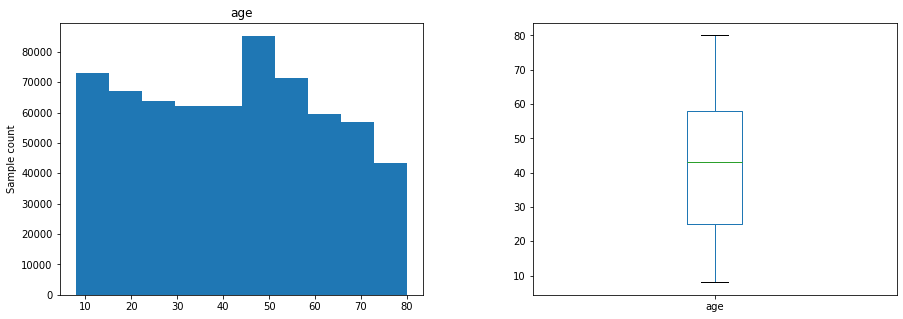

In [6]:
# Include only 8-80 years old
temp = features[(features.age >= 8) & (features.age <= 80)]
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])
print('train :', temp[temp.set == 'training'].shape[0])
print('val :', temp[temp.set == 'evaluation'].shape[0])
print('diff train: ', features[features.set == 'training'].shape[0] - temp[temp.set == 'training'].shape[0])
print('diff val: ', features[features.set == 'evaluation'].shape[0] - temp[temp.set == 'evaluation'].shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
features[['age']].hist(ax=axs[0], grid=False, )
axs[0].set_ylabel("Sample count")
features[['age']].boxplot(ax=axs[1], grid=False)
plt.show()

new N:  642252
diff:  2350
train : 611372
val : 23633
diff train:  2336
diff val:  0
sex
Female    0.571126
Male      0.428874
Name: proportion, dtype: float64


Text(0, 0.5, 'Sample count')

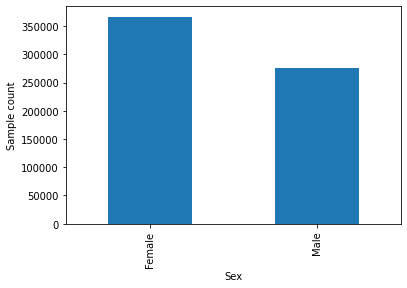

In [7]:
# SEX drop NA
temp = features.dropna(subset=('sex'))
temp = temp[temp.sex!=2] #exclude samples with intersex
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])
print('train :', temp[temp.set == 'training'].shape[0])
print('val :', temp[temp.set == 'evaluation'].shape[0])
print('diff train: ', features[features.set == 'training'].shape[0] - temp[temp.set == 'training'].shape[0])
print('diff val: ', features[features.set == 'evaluation'].shape[0] - temp[temp.set == 'evaluation'].shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
features['sex'] = features['sex'].apply(lambda x: 'Female' if x==0 else 'Male') #rename group 0: F, 1: M
print(features.sex.value_counts(normalize =True, sort = False))
ax = features.sex.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Sex")
ax.set_ylabel("Sample count")

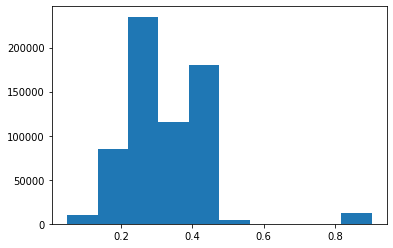

new N:  629906
diff:  12346
train : 602577
val : 20105
diff train:  8795
diff val:  3528


In [8]:
#add missing values rate per sample
features['missingValuesRate']=features.apply(lambda x: x.isnull().sum()/features.shape[1], axis=1) #% of missing values

#visualise missing values rate per sample
features.missingValuesRate.hist(grid=False)
plt.show()

#based on the histogram, all samples with misisng values rate more than 50% will be excluded
temp = features[features.missingValuesRate <= .5]
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])
print('train :', temp[temp.set == 'training'].shape[0])
print('val :', temp[temp.set == 'evaluation'].shape[0])
print('diff train: ', features[features.set == 'training'].shape[0] - temp[temp.set == 'training'].shape[0])
print('diff val: ', features[features.set == 'evaluation'].shape[0] - temp[temp.set == 'evaluation'].shape[0])

features = temp
temp = []
features.drop(columns=['missingValuesRate'], inplace=True)
features.reset_index(drop=True, inplace=True)


In [14]:
features.columns

Index(['patid', 'set', 'sex', 'age', 'BMI', 'ethnic_group', 'smokingStatus',
       'imd_decile', 'CharlsonScore', 'count_rhinitis', 'count_cardiovascular',
       'count_heartfailure', 'count_psoriasis', 'count_anaphylaxis',
       'count_diabetes', 'count_ihd', 'count_anxiety', 'count_eczema',
       'count_nasalpolyps', 'count_paracetamol', 'count_nsaids',
       'count_betablocker', 'PEFStatus', 'EosinophilLevel', 'BTS_step',
       'DeviceType', 'PriorEducation', 'average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS',
       'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI',
       'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks',
       'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
       'numAsthmaReview'],
      dtype='object')

In [16]:
#continuos misisng values to 0
cont_vars = ['average_daily_dose_ICS',
       'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numPCS',
       'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI',
       'numOCSEvents', 'numOCSwithLRTI', 'numAsthmaAttacks',
       'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
       'numAsthmaReview']
# labels = ['Average daily dose of ICS', 'Prescribed daily dose ICS', 'Number of OCS courses', 
#           'Number of primary care consultations', 'Number of asthma-related primary care consultations', 'Number of antibiotics events', 'Number of antibiotics events with LRTI', 
#           'Number of OCS courses with LRTI']
# outliers_check = []
# outlier_threshold = .999 #quantile
# cont_features = features
for var in cont_vars:
    print(var)    
    features[var] = features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)
    
    # cont_features[var] = cont_features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)

average_daily_dose_ICS
prescribed_daily_dose_ICS
ICS_medication_possesion_ratio
numPCS
numPCSAsthma
numAntibioticsEvents
numAntibioticswithLRTI
numOCSEvents
numOCSwithLRTI
numAsthmaAttacks
numAcuteRespEvents
numHospEvents
numAsthmaManagement
numAsthmaReview


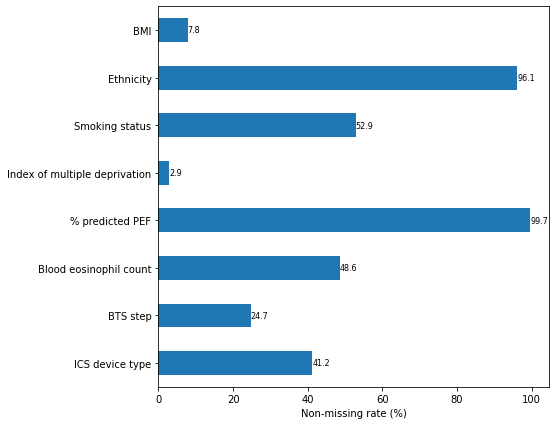

In [25]:
# plot missing values per variable after cleaning the age, sex, and exluding high missing values rate sampls

exclude_vars = ['patid', 'set'] #for visualising missing values
comed_comorb = features.columns[features.columns.str.contains('count')].tolist()
# exclude_vars = exclude_vars + comed_comorb

notnull = features.drop(columns=exclude_vars)
notnull = pd.DataFrame(np.round((notnull.shape[0]-notnull.notnull().sum())/notnull.shape[0], 3)*100, columns=['notnull_rate'])
notnull['var'] = notnull.index
notnull = notnull.replace({'var': var_names_fix})
notnull = notnull[notnull.notnull_rate>0]
notnull.reset_index(inplace=True, drop=True)
ax = notnull.plot.barh(x='var', y='notnull_rate', figsize = (7,7), ylabel = '', xlabel = 'Non-missing rate (%)', legend=False, rot = 0, label='notnull_rate')
ax.bar_label(ax.containers[0], fontsize = 8)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# BMI include only 15-75 
# all other invalid values and NA will be coded as 0 (not recorded)
 # - missing BMI -> replace with 0
 # - invalid BMI (x<15 | x>75) -> replace with 0
temp = features
invalid_bmi = temp[(temp.BMI < 15) | (temp.BMI > 75)].shape[0]
missing_BMI = temp[temp.BMI.isna()].shape[0]
print(f'missing BMI: {missing_BMI}, invalid BMI: {invalid_bmi}')
temp[((temp.BMI < 15) | (temp.BMI > 75))|(temp.BMI.isna())]
temp['BMI'] = temp['BMI'].apply(lambda x: 0  if ((x < 15) | (x > 75))| (math.isnan(x)) else x)
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])
print('train :', temp[temp.set == 'training'].shape[0])
print('val :', temp[temp.set == 'evaluation'].shape[0])
print('diff train: ', features[features.set == 'training'].shape[0] - temp[temp.set == 'training'].shape[0])
print('diff val: ', features[features.set == 'evaluation'].shape[0] - temp[temp.set == 'evaluation'].shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
features[['BMI']].hist(ax=axs[0], grid=False)
axs[0].set_ylabel("Sample count")
features[['BMI']].boxplot(ax=axs[1], grid=False)
plt.show()

In [ ]:
#plot BMI without zero BMI
print('N without 0 BMI: ', features[features.BMI>0].shape[0])
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
features[features.BMI>0][['BMI']].hist(ax=axs[0], grid=False)
axs[0].set_ylabel("Sample count")
features[features.BMI>0][['BMI']].boxplot(ax=axs[1], grid=False)
plt.show()

In [ ]:
# replace NA in ethnicity and ethnic_group with 'not recorded'
# features['ethnicity'] = features.ethnicity.apply(lambda x: 'not recorded' if pd.isnull(x) else x) 
temp = features
temp['ethnic_group'] = temp.ethnic_group.apply(lambda x: 'not recorded' if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['ethnic_group'] = temp["ethnic_group"].astype('category').cat.set_categories(['Asian - ethnic group', 'Black - ethnic group', 'White - ethnic group', 
                                                                                           'Mixed ethnic census group', 'Other ethnic group',  'not recorded',])

def fix_ethnic(x):
    if x=='Asian - ethnic group':
        return 'Asian'
    elif x=='Black - ethnic group':
        return 'Black'
    elif x=='White - ethnic group':
        return 'White'
    elif x=='Mixed ethnic census group':
        return 'Mixed'
    elif x=='Other ethnic group':
        return 'Other'
    elif x=='not recorded':
        return x
        
temp['ethnic_group'] = temp['ethnic_group'].apply(lambda x: fix_ethnic(x) )
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)

print('missing: ', features.ethnic_group.isnull().sum())
print(features.ethnic_group.value_counts(normalize=True, sort=False))

ax = features.ethnic_group.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Sample count")

In [ ]:
#for smoking, anyone with no record, consider them non-smoker
temp = features
temp['smokingStatus'] = temp.smokingStatus.apply(lambda x: 'never' if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['smokingStatus'] = temp["smokingStatus"].astype('category').cat.set_categories(['never', 'former', 'current'])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.smokingStatus.isnull().sum())
print(features.smokingStatus.value_counts(normalize=True, sort=False))
ax = features.smokingStatus.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Smoking status")
ax.set_ylabel("Sample count")

In [ ]:
#for IMD, re-assign those with no data as 0
temp = features
temp['imd_decile'] = temp.imd_decile.apply(lambda x: 0 if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['imd_decile'] = temp["imd_decile"].astype('int').astype('category').cat.set_categories([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.imd_decile.isnull().sum())
print(features.imd_decile.value_counts(normalize=True, sort=False))
ax = features.imd_decile.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("IMD Decile")
ax.set_ylabel("Sample count")

In [ ]:
#for PEF, re-assign those with no data as a 'not_recorded' ---> too many missing values > 96%
temp = features
temp['PEFStatus'] = temp.PEFStatus.apply(lambda x: 'not recorded' if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['PEFStatus'] = temp["PEFStatus"].astype('category').cat.set_categories(['less than 60', '60-80', 'more than 80', 'not recorded'])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.PEFStatus.isnull().sum())
print(features.PEFStatus.value_counts(normalize=True, sort=False))
ax = features.PEFStatus.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("% Predicted PEF")
ax.set_ylabel("Sample count")

In [ ]:
#for Eosinophil, re-assign those with no data as a not recorded
temp = features
temp['EosinophilLevel'] = temp['EosinophilLevel'].apply(lambda x: 'not recorded' if ((pd.isnull(x)) or (x=='unknown')) else x)
temp.reset_index(inplace=True, drop=True)
temp['EosinophilLevel'] = temp["EosinophilLevel"].astype('category').cat.set_categories(['normal', 'high', 'not recorded'])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.EosinophilLevel.isnull().sum())
print(features.EosinophilLevel.value_counts(normalize=True, sort=False))
ax = features.EosinophilLevel.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Blood Eosinophil Count")
ax.set_ylabel("Sample count")

In [ ]:
#BTS Step (if none recorded, it means that they are at step 0
temp = features
temp['BTS_step'] = temp.BTS_step.apply(lambda x: 0 if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['BTS_step'] = temp["BTS_step"].astype('int').astype('category').cat.set_categories([0, 1, 2, 3, 4, 5])
print('new N: ', features.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.BTS_step.isnull().sum())
print(features.BTS_step.value_counts(normalize=True,sort=False))
ax = features.BTS_step.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("BTS step")
ax.set_ylabel("Sample count")

In [ ]:
#for Device type, re-assign those with no data as a 'not recorded'
temp = features
temp['DeviceType'] = temp.DeviceType.apply(lambda x: 'not recorded' if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
temp['DeviceType'] = temp["DeviceType"].astype('category').cat.set_categories(['BAI', 'DPI', 'NEB', 'pMDI', 'not recorded'])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print('missing: ', features.DeviceType.isnull().sum())
print(features.DeviceType.value_counts(normalize=True,sort=False))
ax = features.DeviceType.value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Device Type")
ax.set_ylabel("Sample count")

In [ ]:
#Prior asthma education


def fix_priorAsthmaEducation(x):
    if x==1 :
        return 'Yes'
    elif x==0 :
        return 'No'
    elif x!=np.nan:
        return 'not recorded'

temp = features
temp['PriorEducation'] = temp.PriorEducation.apply(lambda x: fix_priorAsthmaEducation(x))
temp.reset_index(inplace=True, drop=True)
temp['PriorEducation'] = temp["PriorEducation"].astype('category').cat.set_categories(['Yes', 'No', 'not recorded'])
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
print(features.PriorEducation.value_counts(normalize=True,sort=False))
features.PriorEducation.value_counts(sort=False).plot(kind='bar')

In [ ]:
#Charlson's commorbidity index
temp = features
temp['CharlsonScore'] = temp.CharlsonScore.apply(lambda x: 0 if pd.isnull(x) else x)
temp.reset_index(inplace=True, drop=True)
print('new N: ', temp.shape[0])
print('diff: ', features.shape[0] - temp.shape[0])

features = temp
temp = []
features.reset_index(drop=True, inplace=True)
ax = pd.DataFrame(features.CharlsonScore.value_counts(dropna=False)).sort_index().plot.bar(xlabel = "Charlson's Commorbidity Index", legend=False)
ax.bar_label(ax.containers[0], fontsize = 7)

In [ ]:
# #asthma attack month (NA to zero)
# month_cols = features.columns[features.columns.str.contains('month')]
# for col in month_cols:
#     print(col)
#     features[col][features[col].isna()] = 0
# features.reset_index(inplace=True, drop=True)
# print('new N: ', temp.shape[0])
# print('diff: ', features.shape[0] - temp.shape[0])

In [ ]:
features.columns

In [ ]:
# explore outliers in continous variables. Exclude samples more than .99 quantile

cont_vars = ['average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numOCSEvents', 
             'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 
             'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
             'numAsthmaReview', 'numAsthmaMedReview', 'numAsthmaReviewRCP' ]
labels = ['Average daily dose of ICS', 'Prescribed daily dose ICS', 'ICS medication possesion ratio', 'Number of OCS courses', 
          'Number of primary care consultations', 'Number of asthma-related primary care consultations', 'Number of antibiotics events', 'Number of antibiotics events with LRTI', 
          'Number of OCS courses with LRTI', 'Number of asthma attacks', 'Number of acute respiratory events', 'Number of hospitalisation events (recorded in primary care)', 
          'Number of previous asthma mangement plan given', 'Number of previous asthma annual review', 'Number of previous asthma medication review', 
          'Number of previous asthma review (Royal College of Physicians']
outliers_check = []
outlier_threshold = .999 #quantile
cont_features = features
for var, label in zip(cont_vars, labels):
    print(var)    
    features[var] = features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)
    fig = plt.figure()
    a = features[[var]]
    a = a.rename(columns={var: label})
    a.boxplot(grid=False, tick_labels = [" "])
    plt.show()


    
    cont_features[var] = cont_features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)
    initial_max = max(features[var])
    initial_min = min(features[var])
    print(f'max: {initial_max}, min: {initial_min}')
    n_outliers = cont_features[cont_features[var] > features[var].quantile(outlier_threshold)].shape[0]
    print(f'n outliers: {n_outliers}')
    cont_features = cont_features[cont_features[var] <= features[var].quantile(outlier_threshold)]
    new_max = max(cont_features[var])
    new_min = min(cont_features[var])
    print(f'new max: {new_max}, new min: {new_min}')
    outliers_check.append([label, outlier_threshold, initial_max, initial_min, n_outliers, new_max, new_min])
    cont_features.reset_index(inplace=True, drop=True)
    # fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # features[[var]].hist(ax=axs[0], )
    # features[[var]].plot(kind='hist', bins=10, ax=axs[0])
    # plt.show()
    fig = plt.figure()
    a = cont_features[[var]]
    a = a.rename(columns={var: label})
    a.boxplot(grid=False, tick_labels = [" "])
    plt.show()
    fig.savefig('../Clean_data/'+var+'.png')



In [ ]:
outliers_check = pd.DataFrame(outliers_check, columns=['variable', 'percentile', 'initial max', 'initial min', 'n outliers', 'new max', 'new min'])
outliers_check['n outliers'].sum()

In [ ]:
outliers_check

In [ ]:
# based on above table, I decided to exclude some variables from outliers removal due to very narrow min-max gap: 'ICS_medication_possesion_ratio', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
#             'numAsthmaReview', 'numAsthmaMedReview', 'numAsthmaReviewRCP'
# do the same outliers removal step and overwrite dataframe

# explore outliers in continous variables. Exclude samples more than .99 quantile

cont_vars = ['average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'numOCSEvents', 
             'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 
             'numOCSwithLRTI',  ]
labels = ['Average daily dose of ICS', 'Prescribed daily dose ICS', 'Number of OCS courses', 
          'Number of primary care consultations', 'Number of asthma-related primary care consultations', 'Number of antibiotics events', 'Number of antibiotics events with LRTI', 
          'Number of OCS courses with LRTI']
outliers_check = []
outlier_threshold = .999 #quantile
cont_features = features
for var, label in zip(cont_vars, labels):
    print(var)    
    features[var] = features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)

    
    cont_features[var] = cont_features[var].apply(lambda x: 0 if pd.isnull(x) | math.isinf(x) else x)
    initial_max = max(features[var])
    initial_min = min(features[var])
    print(f'max: {initial_max}, min: {initial_min}')
    n_outliers = cont_features[cont_features[var] > features[var].quantile(outlier_threshold)].shape[0]
    print(f'n outliers: {n_outliers}')
    cont_features = cont_features[cont_features[var] <= features[var].quantile(outlier_threshold)]
    new_max = max(cont_features[var])
    new_min = min(cont_features[var])
    print(f'new max: {new_max}, new min: {new_min}')
    outliers_check.append([label, outlier_threshold, initial_max, initial_min, n_outliers, new_max, new_min])
    cont_features.reset_index(inplace=True, drop=True)


print('new N: ', cont_features.shape[0])
print('diff: ', features.shape[0] - cont_features.shape[0])
print('train :', cont_features[cont_features.set == 'training'].shape[0])
print('val :', cont_features[cont_features.set == 'evaluation'].shape[0])
print('diff train: ', features[features.set == 'training'].shape[0] - cont_features[cont_features.set == 'training'].shape[0])
print('diff val: ', features[features.set == 'evaluation'].shape[0] - cont_features[cont_features.set == 'evaluation'].shape[0])

features = cont_features

In [ ]:
#corelation heat map
cont_vars = ['average_daily_dose_ICS', 'prescribed_daily_dose_ICS', 'ICS_medication_possesion_ratio', 'numOCSEvents', 
             'numPCS', 'numPCSAsthma', 'numAntibioticsEvents', 'numAntibioticswithLRTI', 
             'numOCSwithLRTI', 'numAsthmaAttacks', 'numAcuteRespEvents', 'numHospEvents', 'numAsthmaManagement',
             'numAsthmaReview', 
             # 'numAsthmaMedReview', 'numAsthmaReviewRCP' 
            ]
a = features[cont_vars]
a = a.rename(columns=var_names_fix)
corr = a.corr()
f, ax = plt.subplots(figsize=(15, 10))
# corr = dataframe.corr()
sns.set(font_scale=1)
sns.heatmap(corr, annot = True,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax,
           annot_kws={"fontsize":10})

In [ ]:
# plot missing values per variable after cleaning the age, sex, and exluding high missing values rate sampls

exclude_vars = ['patid', 'set'] #for visualising missing values
comed_comorb = features.columns[features.columns.str.contains('count')].tolist()
# exclude_vars = exclude_vars + comed_comorb

notnull = features.drop(columns=exclude_vars)
notnull = pd.DataFrame(np.round(notnull.notnull().sum()/notnull.shape[0], 5)*100, columns=['notnull_rate'])
notnull['var'] = notnull.index
notnull = notnull.replace({'var': var_names_fix})
notnull.reset_index(inplace=True, drop=True)
ax = notnull.plot.barh(x='var', y='notnull_rate', figsize = (6,15), ylabel = '', xlabel = 'Non-missing rate (%)', legend=False, rot = 0, label='notnull_rate')
ax.bar_label(ax.containers[0], fontsize = 8)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# features.average_daily_dose_ICS[features.average_daily_dose_ICS.isna()] = 0
# features.prescribed_daily_dose_ICS[features.prescribed_daily_dose_ICS.isna()] = 0
# features.ICS_medication_possesion_ratio[features.ICS_medication_possesion_ratio.isna()] = 0
# features.Spacer[features.Spacer.isna()] = 0
# features.numOCS[features.numOCS.isna()] = 0
# features.numPCS[features.numPCS.isna()] = 0
# features.numAntibioticsEvents[features.numAntibioticsEvents.isna()] = 0
# features.numAntibioticswithLRTI[features.numAntibioticswithLRTI.isna()] = 0
# features.numOCSEvents[features.numOCSEvents.isna()] = 0
# features.numOCSwithLRTI[features.numOCSwithLRTI.isna()] = 0
# features.numAsthmaAttacks[features.numAsthmaAttacks.isna()] = 0
# features.numAcuteRespEvents[features.numAcuteRespEvents.isna()] = 0
# features.PriorEducation[features.PriorEducation.isna()] = 0
# features.numPCSAsthma[features.numPCSAsthma.isna()] = 0
# features.CharlsonScore[features.CharlsonScore.isna()] = 0
# features.numHospEvents[features.numHospEvents.isna()] = 0
# features.reset_index(inplace=True, drop=True)
# print('new N: ', temp.shape[0])
# print('diff: ', features.shape[0] -  temp.shape[0])

## Categorized cont vars

In [ ]:
#BMI
def cat_bmi(x):
    if (x==0):
        return 'not recorded'
    elif (x<20): 
        return 'underweight'
    elif (x>=20) & (x<25):
        return 'normal'
    elif (x>=25) & (x<30):
        return 'overweight'
    elif (x>=30):
        return 'obese'
    
    
features['BMI_cat'] = features.BMI.apply(lambda x: cat_bmi(x))
features.reset_index(inplace=True, drop=True)
features.shape

In [ ]:
#Age
def cat_age(x):
    if (x<12):
        return 'younger than 12'
    elif (x>=12) & (x<18):
        return '12-17'
    elif (x>=18) & (x<35):
        return '18-34'
    elif (x>=35) & (x<55):
        return '35-54'
    elif (x>=55) & (x<75):
        return '55-74'
    elif (x>=75):
        return '>=75'
    
features['age_cat'] = features.age.apply(lambda x: cat_age(x))
features.reset_index(inplace=True, drop=True)
features.shape

In [ ]:
#Average daily ICS
def cat_ics(x):
    if (x==0):
        return '0'
    elif (x>0) & (x<=200):
        return '1-200'
    elif (x>200) & (x<=400):
        return '201-400'
    elif (x>400):
        return '>400'
    
features['average_daily_dose_ICS_cat'] = features.average_daily_dose_ICS.apply(lambda x: cat_ics(x))
features['prescribed_daily_dose_ICS_cat'] = features.prescribed_daily_dose_ICS.apply(lambda x: cat_ics(x))
features.reset_index(inplace=True, drop=True)
features.shape


In [ ]:
#cat ICS medication ratio
def cat_ics_medication(x):
    if x==0:
        return 'No ICS Prescribed'
    elif (x>0) & (x<0.40):
        return '>0%-39.9%'
    elif (x>=0.40) & (x<.60):
        return '40%-59.9%'
    elif (x>0.60) :
        return '>=60%'
    
features['ICS_medication_possesion_ratio_cat'] = features.ICS_medication_possesion_ratio.apply(lambda x: cat_ics_medication(x))
features.reset_index(inplace=True, drop=True)
features.shape


In [ ]:
#cat other continuous vars
def cat_continuous(x):
    if x==0:
        return '0'
    elif x==1:
        return '1'
    elif x==2:
        return '2'
    elif (x>2) :
        return '>=3'
    
features['numOCS_cat'] = features.numOCSEvents.apply(lambda x: cat_continuous(x))
features['numOCSEvents_cat'] = features.numOCSEvents.apply(lambda x: cat_continuous(x))
features['numOCSwithLRTI_cat'] = features.numOCSwithLRTI.apply(lambda x: cat_continuous(x))
features['numAcuteRespEvents_cat'] = features.numAcuteRespEvents.apply(lambda x: cat_continuous(x))
features['numAntibioticsEvents_cat'] = features.numAntibioticsEvents.apply(lambda x: cat_continuous(x))
features['numAntibioticswithLRTI_cat'] = features.numAntibioticswithLRTI.apply(lambda x: cat_continuous(x))
features['numAsthmaAttacks_cat'] = features.numAsthmaAttacks.apply(lambda x: cat_continuous(x))
features['numHospEvents_cat'] = features.numHospEvents.apply(lambda x: cat_continuous(x))
features['numPCS_cat'] = features.numPCS.apply(lambda x: cat_continuous(x))
features['numPCSAsthma_cat'] = features.numPCSAsthma.apply(lambda x: cat_continuous(x))
features['numAsthmaManagement_cat'] = features.numAsthmaManagement.apply(lambda x: cat_continuous(x))
features['numAsthmaReview_cat'] = features.numAsthmaReview.apply(lambda x: cat_continuous(x))
features['numAsthmaMedReview_cat'] = features.numAsthmaMedReview.apply(lambda x: cat_continuous(x))
features['numAsthmaReviewRCP_cat'] = features.numAsthmaReviewRCP.apply(lambda x: cat_continuous(x))
features.reset_index(inplace=True, drop=True)
features.shape

In [ ]:
#transform comorbidity and comedication into binary
def count2cat(x):
    if x == 0:
        return 0
    else:
        return 1
        
countVars = features.columns[features.columns.str.contains('count')]
for var in countVars:
    features[var.split('_')[1]] = features.apply(lambda x: count2cat(x[var]), axis=1)
features.reset_index(inplace=True, drop=True)

In [ ]:
comorbidities = ['rhinitis', 'cardiovascular', 'heartfailure', 'psoriasis', 'anaphylaxis',
                 'diabetes', 'ihd', 'anxiety', 'eczema', 'nasalpolyps']
comedications = ['paracetamol', 'nsaids', 'betablocker']

In [ ]:
# fig, axs = plt.subplots(7, 2, figsize=(15, 5))

# for i in range(7):
#     for j in range(2):
#         print(f'{i}, {j}')
#         col = com_columns[(i+1)*(i+1)]
#         a = features[[col]]
#         a.boxplot(ax=axs[i,j])
# plt.show()

for col in comorbidities:
    print(features[col].value_counts())
    fig = plt.figure()
    a = features[col].value_counts(sort=False).plot(kind='bar', )
    a.set_ylabel("Sample count", labelpad = 1)
    plt.show()
    fig.savefig('../Clean_data/'+col+'.png')

In [ ]:
for col in comedications:
    fig = plt.figure()
    print(features[col].value_counts())
    a = features[col].value_counts(sort=False).plot(kind='bar', )
    a.set_ylabel("Sample count", labelpad = 1)
    plt.show()
    fig.savefig('../Clean_data/'+col+'.png')

In [ ]:
#code sex variable into 0=female and 1=male
features['sex'] = features['sex'].apply(lambda x: 0 if x=='Female' else 1)

In [ ]:
#final check for the missing values
# plot missing values per variable after cleaning the age, sex, and exluding high missing values rate sampls

exclude_vars = ['patid', 'set'] #for visualising missing values
comed_comorb = features.columns[features.columns.str.contains('count')].tolist()
# exclude_vars = exclude_vars + comed_comorb

notnull = features.drop(columns=exclude_vars)
notnull = pd.DataFrame(np.round(notnull.notnull().sum()/notnull.shape[0], 5)*100, columns=['notnull_rate'])
notnull['var'] = notnull.index
notnull = notnull.replace({'var': var_names_fix})
notnull.reset_index(inplace=True, drop=True)
ax = notnull.plot.barh(x='var', y='notnull_rate', figsize = (6,15), ylabel = '', xlabel = 'Non-missing rate (%)', legend=False, rot = 0, label='notnull_rate')
ax.bar_label(ax.containers[0], fontsize = 8)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
pd.options.display.max_rows = 287
features.isna().sum()

In [ ]:
#final check for cat vars
cat_vars = ['age_cat',
'ICS_medication_possesion_ratio_cat', 'numOCS_cat',
'numOCSEvents_cat', 'numOCSwithLRTI_cat', 'numAcuteRespEvents_cat',
'numAntibioticsEvents_cat', 'numAntibioticswithLRTI_cat',
'numAsthmaAttacks_cat', 'numHospEvents_cat', 'numPCS_cat',
'numPCSAsthma_cat', 'numAsthmaManagement_cat',
'numAsthmaReview_cat', 'numAsthmaMedReview_cat',
'numAsthmaReviewRCP_cat']
for var in cat_vars:
    print(var, features[var].unique())

In [ ]:
features.to_csv('../Clean_data/cleaned_features_22102024.csv', index_label=False, index=False)
pickle.dump(features, open('../Clean_data/cleaned_features_22102024.sav', 'wb'))

# Outcome

In [ ]:
outcomes = pd.read_csv('../Clean_data/data_outcomes_2vs1_15112023.csv')
outcomes = outcomes.iloc[:,1:]
#select only patients included in features
outcomes = outcomes[outcomes.patid.isin(features.patid.values)]
outcomes.shape

In [ ]:
outcomes.outcome_12months.value_counts(normalize=True)

In [ ]:
# outcomes["outcome_combined_6months"] = outcomes.apply(lambda x: (x["outcome_3months"] | x["outcome_6months"]), axis=1)
# outcomes["outcome_combined_9months"] = outcomes.apply(lambda x: (x["outcome_combined_6months"] | x["outcome_9months"]), axis=1)
# outcomes["outcome_combined_12months"] = outcomes.apply(lambda x: (x["outcome_combined_9months"] | x["outcome_12months"]), axis=1)
# outcomes["outcome_combined_15months"] = outcomes.apply(lambda x: (x["outcome_combined_12months"] | x["outcome_15months"]), axis=1)
# outcomes["outcome_combined_18months"] = outcomes.apply(lambda x: (x["outcome_combined_15months"] | x["outcome_18months"]), axis=1)
# outcomes["outcome_combined_24months"] = outcomes.apply(lambda x: (x["outcome_combined_18months"] | x["outcome_24months"]), axis=1)

# outcomes['3MonthsOutcome'] = outcomes.apply(lambda x: x.outcome_3months, axis=1)
outcomes['outcome_6months'] = outcomes.apply(lambda x: (x.outcome_3months)|(x.outcome_6months), axis=1)
outcomes['outcome_9months'] = outcomes.apply(lambda x: (x.outcome_6months)|(x.outcome_9months), axis=1)
outcomes['outcome_12months'] = outcomes.apply(lambda x: (x.outcome_9months)|(x.outcome_12months), axis=1)
outcomes.shape

In [ ]:
outcomes.outcome_12months.value_counts(normalize=True)

In [ ]:
outcomes.to_csv('../Clean_data/cleaned_outcomes_24102024.csv', index_label=False, index=False)
pickle.dump(outcomes, open('../Clean_data/cleaned_outcomes_24102024.sav', 'wb'))